<a href="https://colab.research.google.com/github/shreenithi23/SubSight/blob/main/SubSight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# reading the data
data = pd.read_csv('subscriptions.csv')
print(data.head())

  Time Period  Subscribers
0  01/04/2013     34240000
1  01/07/2013     35640000
2  01/10/2013     38010000
3  01/01/2014     41430000
4  01/04/2014     46130000


In [ ]:
data['Time Period'] = pd.to_datetime(data['Time Period'],
                                     format='%d/%m/%Y')
print(data.head())

  Time Period  Subscribers
0  2013-04-01     34240000
1  2013-07-01     35640000
2  2013-10-01     38010000
3  2014-01-01     41430000
4  2014-04-01     46130000


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Time Period'],
                         y=data['Subscribers'],
                         mode='lines', name='Subscribers'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                  xaxis_title='Date',
                  yaxis_title='Netflix Subscriptions')
fig.show()

In [ ]:
#quarterly growth rate, calculating the percentage change between consecutive rows and multiplying it by 100 to convert it to percentage
data['Quarterly Growth Rate'] = data['Subscribers'].pct_change() * 100

#green for positive growth and red for negative growth
data['Bar Color'] = data['Quarterly Growth Rate'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Time Period'],
    y=data['Quarterly Growth Rate'],
    marker_color=data['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)')
fig.show()

In [ ]:
# Calculate the yearly growth rate
data['Year'] = data['Time Period'].dt.year
yearly_growth = data.groupby('Year')['Subscribers'].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar Color'] = yearly_growth.apply(lambda x: 'green' if x > 0 else 'red')

# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
# fig.add_trace(go.Bar(
#     x=data['Year'],
#     y=yearly_growth,
#     marker_color=data['Bar Color'],
#     name='Yearly Growth Rate'
# ))
fig.update_layout(title='Netflix Yearly Subscriber Growth Rate',
                  xaxis_title='Year',
                  yaxis_title='Yearly Growth Rate (%)')
fig.add_trace(go.Bar(
    x=data['Year'],
    y=yearly_growth,
    marker_color=data['Bar Color'],
    name='Yearly Growth Rate',
    hovertemplate='<b>Year:</b> %{x}<br><b>Growth Rate:</b> %{y:.2f}%<extra></extra>'
))



fig.show()

acf-how correlated the time series is with its past values(lags).
Lag1 - shows significant positive correlation-> strong dependency with previous step
After lag 1 -> correlations drop quickly and oscillate around zero within the confidence interval

pacf- direct effect of each lag on current observation
here also significant spike in lag 1-> strong positive correlation
and other values around zero within the confidence interval

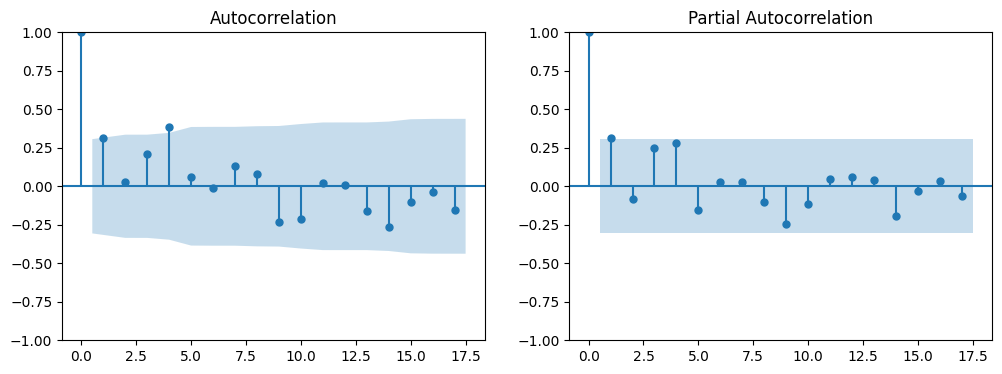

In [ ]:
time_series = data.set_index('Time Period')['Subscribers']
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

lower AIC,BIC is better while comparing different ARIMA models.
higher log likelihood is preferred


In [ ]:
p, d, q = 1, 1, 1
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Tue, 17 Dec 2024   AIC                           1351.986
Time:                        12:46:43   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.765      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

In [ ]:
# p, d, q = 2, 1, 1
# model = ARIMA(time_series, order=(p, d, q))
# results = model.fit()
# print(results.summary())

In [ ]:
future_steps = 10
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
predictions

,predicted_mean
2023-10-01,243321458
2024-01-01,248251648
2024-04-01,253180570
2024-07-01,258108224
2024-10-01,263034611
2025-01-01,267959731
2025-04-01,272883584
2025-07-01,277806171
2025-10-01,282727492
2026-01-01,287647547


In [ ]:
# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='Netflix Quarterly Subscription Predictions',
                  xaxis_title='Time Period',
                  yaxis_title='Subscribers',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()

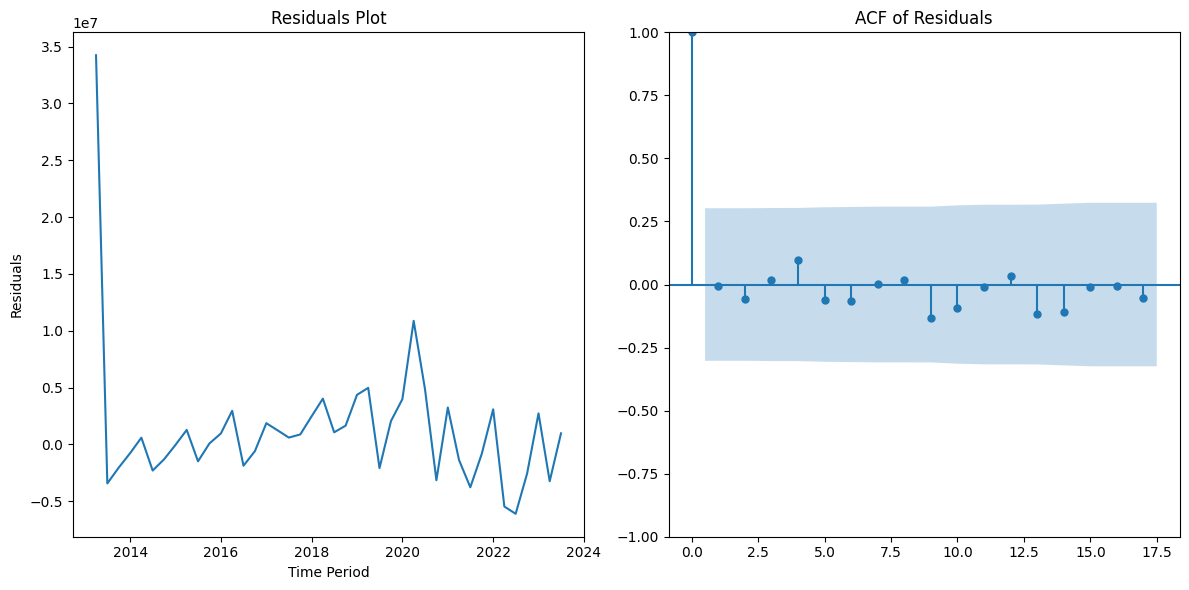

In [ ]:
residuals=results.resid
#residual=observed-predicted

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals Plot')
plt.xlabel('Time Period')
plt.ylabel('Residuals')

# ACF of residuals
plt.subplot(1, 2, 2)
plot_acf(residuals, ax=plt.gca())
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

In [ ]:
p_values = [1, 2, 3]  # AR terms
d_values = [0, 1]     # Differencing
q_values = [1, 2, 3]  # MA terms

best_aic = float('inf')
best_bic = float('inf')
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(time_series, order=(p, d, q))
                results = model.fit()
                aic = results.aic
                bic = results.bic
                print(f"ARIMA({p}, {d}, {q}) - AIC: {aic}, BIC: {bic}")
                if aic < best_aic and bic < best_bic:
                    best_aic = aic
                    best_bic = bic
                    best_order = (p, d, q)

            except Exception as e:
                print(f"ARIMA({p}, {d}, {q}) could not be fitted due to: {e}")

print(f"\nBest ARIMA order: {best_order} with AIC: {best_aic}, BIC: {best_bic}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No freq

ARIMA(1, 0, 1) - AIC: 1423.5100633023035, BIC: 1430.4607417754369
ARIMA(1, 0, 2) - AIC: 1424.3633777006955, BIC: 1433.0517257921124


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No freq

ARIMA(1, 0, 3) - AIC: 1426.5131667370385, BIC: 1436.9391844467389
ARIMA(1, 1, 1) - AIC: 1351.9862375842608, BIC: 1357.1269537843737


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency informat

ARIMA(1, 1, 2) - AIC: 1353.7862408423855, BIC: 1360.6405291092028
ARIMA(1, 1, 3) - AIC: 1356.1844388965742, BIC: 1364.7522992300958


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency informat

ARIMA(2, 0, 1) - AIC: 1390.6061479836985, BIC: 1399.2944960751154
ARIMA(2, 0, 2) - AIC: 1389.1087295216994, BIC: 1399.5347472313997


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



ARIMA(2, 0, 3) - AIC: 1393.0792716422181, BIC: 1405.2429589702017


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum

ARIMA(2, 1, 1) - AIC: 1353.343166287849, BIC: 1360.1974545546664
ARIMA(2, 1, 2) - AIC: 1355.7204347466306, BIC: 1364.2882950801522


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



ARIMA(2, 1, 3) - AIC: 1358.1763352053463, BIC: 1368.4577676055721


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



ARIMA(3, 0, 1) - AIC: 1392.151365558785, BIC: 1402.5773832684854


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum

ARIMA(3, 0, 2) - AIC: 1391.804601805832, BIC: 1403.9682891338155
ARIMA(3, 0, 3) - AIC: 1395.0560882063505, BIC: 1408.9574451526175


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provid

ARIMA(3, 1, 1) - AIC: 1355.040566774649, BIC: 1363.6084271081706


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



ARIMA(3, 1, 2) - AIC: 1357.25979493632, BIC: 1367.541227336546
ARIMA(3, 1, 3) - AIC: 1352.7735508817561, BIC: 1364.7685553486863

Best ARIMA order: (1, 1, 1) with AIC: 1351.9862375842608, BIC: 1357.1269537843737


In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adf_test_result = adfuller(residuals, autolag='AIC')
print("ADF Statistic:", adf_test_result[0])
print("p-value:", adf_test_result[1])
print("Critical Values:", adf_test_result[4])

ADF Statistic: -12.038423844690785
p-value: 2.768265203260225e-22
Critical Values: {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}


ADF statistic is less than critical values then we reject the null hypothesis meaning series is stationary.
p-value less than 0.05 -> stationarity

Check the normality and white noise assumption of the residuals
shapiro test-check if the residuals are normally distributed
Ljung box test- checks if the residuals are white noise

In [ ]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

shapiro_test_result = shapiro(residuals)
if shapiro_test_result.pvalue < 0.05:
    print("Residuals are not normally distributed (p-value < 0.05).")
else:
    print("Residuals are normally distributed (p-value >= 0.05).")

lb_test_result = acorr_ljungbox(residuals, lags=[1], return_df=True)
if lb_test_result["lb_pvalue"].iloc[0] < 0.05:
    print("Residuals are not white noise (p-value < 0.05).")
else:
    print("Residuals are white noise (p-value >= 0.05).")

Residuals are not normally distributed (p-value < 0.05).
Residuals are white noise (p-value >= 0.05).
